In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MaxAbsScaler, LabelBinarizer, OneHotEncoder
from sklearn.svm import SVR
import random
import cv2
from scipy import stats
import os


In [2]:
# Add tensorboard stuff
# %load_ext tensorboard
# import datetime

# !rm -rf ./logs/


In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" #use only cpu

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read Depth Camera

In [4]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             gray_frame = frame/np.maximum(np.max(frame),255) keep as int8 for memory savings
            gray_frame = frame
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [5]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [6]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [7]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)

n_test = (24,30,31,32,33,35)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0

subj = ['leo','leo','leo','leo','leo','leo']
        
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    train_dcamera_path = os.path.join(data_dir , 'depth_processed_'+subj[i]+'_test'+str(n_test[i])+'.avi')
    xtemp[i] = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize).astype('uint8')
    


In [8]:
tlen=0
for x in range(len(xtemp)):
    tlen+= xtemp[x].shape[0]
xrun_cum = 0
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]),dtype='uint8')
for i in range (len(xtemp)):
    xrun_n = len(xtemp[i])
    x_train[xrun_cum:xrun_cum+xrun_n,:,:,:] = xtemp[i][:xrun_n,:,:,:]
    xrun_cum += xrun_n

In [9]:
print(x_train.shape)
del xtemp

(77849, 60, 80, 3)


# read fcss data

In [10]:

n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
subj = ['leo','leo','leo','leo','leo','leo']
subjwgt = [67, 67, 67, 67, 67, 67]
subjht = [174, 174, 174, 174, 174, 174]
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    fcss_data_dir = os.path.join(data_dir , 'fcss_processed_'+subj[i]+'_' + test_str + '_' + date[i] + '.txt')
    xfcss_gttemp = pd.read_csv(fcss_data_dir)/subjwgt[i]*subjht[i]**2
    xfcss_gt[i]=xfcss_gttemp
#     xfcss_gt[i]['weight'] = subjwgt[i]# hacky but will work for now
#     xfcss_gt[i]['height'] = subjht[i]# hacky but will work for now
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

# Read Output Data


In [11]:

n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
subj = ['leo','leo','leo','leo','leo','leo']
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    qtm_file_data_dir = os.path.join(data_dir , 'qtm_processed_'+subj[i]+'_test' + str(n_test[i]) + '_' + date[i] + '.txt')
    y_gt[i] = read_output_data(qtm_file_data_dir,theta_interest).values



In [12]:
tlen=0
for x in range(len(y_gt)):
    tlen+= y_gt[x].shape[0]
yrun_cum = 0
y_train = np.zeros((tlen,1))
for i in range (len(y_gt)):
    yrun_n = len(y_gt[i])
    y_train[yrun_cum:yrun_cum+yrun_n] = y_gt[i][:]
    yrun_cum += yrun_n

In [13]:
# Saturate output
def saturate(theta, min_val, max_val):
    for i in range(len(theta)):
        if theta[i] < min_val:
            theta[i] = min_val
            continue
        if theta[i] > max_val:
            theta[i] = max_val
            continue
    return theta

def round_of_rating(number):
    """Round a number to the closest half integer.
    >>> round_of_rating(1.3)
    1.5
    >>> round_of_rating(2.6)
    2.5
    >>> round_of_rating(3.0)
    3.0
    >>> round_of_rating(4.1)
    4.0"""

    return np.round(number * 2) / 2

min_val = -40
max_val = 40
    
y_train = round_of_rating(saturate(y_train, min_val, max_val))



In [14]:
r_int = 0.5
slist = np.arange(min_val,max_val+r_int,r_int)*2 #multiply by 2 to allow labelbinarizer to work

In [15]:
lb = LabelBinarizer()

In [16]:
lb.fit(slist)

LabelBinarizer()

In [17]:
ylabels = lb.transform(y_train*2)

In [18]:
print(x_train.shape)
print(xfcss_train.shape)
print(ylabels.shape)

(77849, 60, 80, 3)
(77849, 6)
(77849, 161)


In [19]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [48]:
Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [49]:
# sc_X2 = StandardScaler()
# sc_y = StandardScaler()

sc_X2 = MaxAbsScaler()
#sc_y = MaxAbsScaler() #not needed at this time

In [50]:
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = lb.transform(ytrainz*2) #scale output by 2 to allow intervals of 0.5

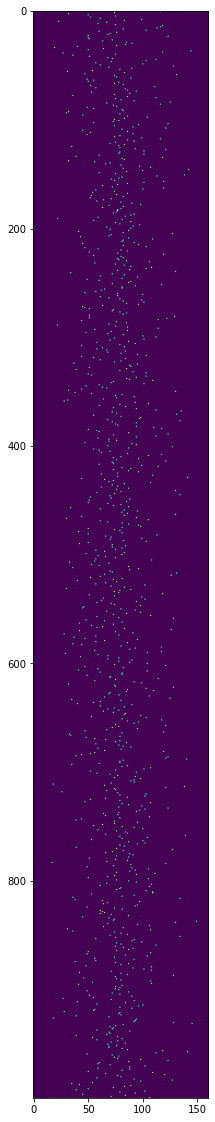

In [53]:
plt.figure(figsize=(20,20))
plt.imshow(y[:1000,:])

In [23]:
#make validation data available to model.fit
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = lb.transform(y_valid*2) #scale output by 2 to allow intervals of 0.5


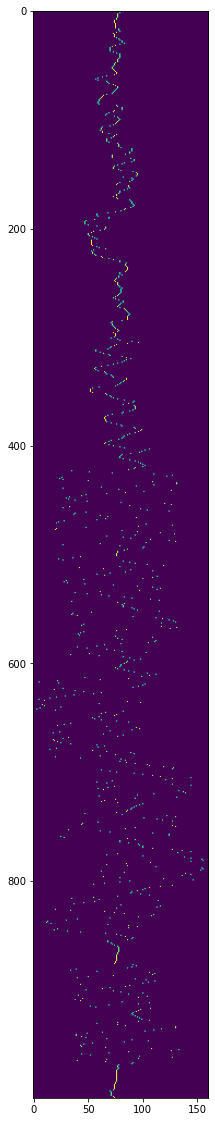

In [54]:
plt.figure(figsize=(20,20))
plt.imshow(y_valid[:1000,:])

In [24]:
# clear up some used variables
del Trainset
del Trainset2
del Testset
del Testset2


In [25]:
y.shape[1]

161

# Regress using Neural Network

In [116]:
# Create Neural Netowrk

from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
from tensorflow.keras.models import Model
dropout_rate = 0.2

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_start2 = Input(shape=(xfcss_train.shape[1],))
model_cnn = model_start
model_perc = model_start2

model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Flatten()(model_cnn)
# model_perc = Flatten()(model_perc)
# model_cnn = Activation('relu')(model_cnn)

model_cnn = Dense(100)(model_cnn)
model_cnn = Activation('relu')(model_cnn)


model_comb = concatenate([model_cnn,model_perc],axis=-1)

model_comb = Dense(128)(model_comb)
model_comb = BatchNormalization()(model_comb)
model_comb = Activation('relu')(model_comb)
model_comb = Dropout(dropout_rate)(model_comb)

output = Dense(y.shape[1])(model_comb)
output = Activation('sigmoid', name='thetaz_out')(output)
model = Model(inputs=[model_start,model_start2],outputs=output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50,restore_best_weights=True) #Moving to 1000 patience.


In [117]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 60, 80, 8)    216         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 60, 80, 8)    32          conv2d_48[0][0]                  
__________________________________________________________________________________________________
activation_69 (Activation)      (None, 60, 80, 8)    0           batch_normalization_19[0][0]     
______________________________________________________________________________________

In [118]:
print(tf.__version__)

2.3.1


In [119]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [120]:
from tensorflow.keras import layers
with tf.device('/device:CPU:0'):
    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomRotation(0.05),
        layers.experimental.preprocessing.RandomZoom(height_factor = (-0.2,0.2),
                                               width_factor = (-0.2,0.2), 
                                               fill_mode = 'constant'),
        ], 
        name='data_augmentation')

# create data generator
def get_generator_cyclic(features1, features2, labels, batch_size=256):
    while True:
        for n in range(int(len(features1)/batch_size)):
            X = features1[n*batch_size: (n+1)*batch_size]
            with tf.device('/device:CPU:0'): #to prevent hogging limited gpu space
                augmented_images = data_augmentation(X)
                Xnew =  tf.cast(augmented_images,tf.float64)/255
            yield [Xnew, features2[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size]]
        permuted = np.random.permutation(len(features1))
        features1 = features1[permuted]
        features2 = features2[permuted]
        labels = labels[permuted]


In [125]:
def scheduler(epoch, lr):
    if e%300 < 200: #very hacky
        return 0.01
    else:
        if e%25==0 & batches==0:
            return lr * 0.99
        else:
            return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [126]:
from datetime import datetime
batch_size = 64
batch_mult = 8
readin = int(batch_size*batch_mult)
#epochs = int(1200)
epochs = int(5)
acc_best = 0
training_generator = get_generator_cyclic(X,X2,y,readin)
# test_generator = get_generator_cyclic(Xvalid,Xvalid2,y_valid,readin)
for e in range(epochs):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print('Epoch', e,'Time: ', current_time)
    batches = 0
    while batches< len(X)/readin:
        Xtrain_1, Xtrain_2, ytrain_1 = next(training_generator)
#         Xtest_1, Xtest_2, ytest_1 =next(test_generator)
#         model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],validation_data = ([Xtest_1,Xtest_2], ytest_1),batch_size=batch_size,verbose = 0)
        model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],batch_size=batch_size,verbose = 0)
        batches += 1
    
    #calculates and prints the running validation once per epoch
    losssc, acc = model.evaluate([Xvalid/255.,Xvalid2],y_valid,verbose=0)
    #mae = lb.inverse_transform(np.array(maesc).reshape(1,-1))[0][0]
    if acc>acc_best:
        modelbest = model
        acc_best = acc
    print('Accuracy at {:4.0f} is: {:4.2f}'.format(e,acc))
modelbest.save('cnn3v31')    

Epoch 0 Time:  02:58:56
Accuracy at    0 is: 0.04
Epoch 1 Time:  02:59:37
Accuracy at    1 is: 0.07
Epoch 2 Time:  03:00:18
Accuracy at    2 is: 0.07
Epoch 3 Time:  03:00:59
Accuracy at    3 is: 0.10
Epoch 4 Time:  03:01:39
Accuracy at    4 is: 0.09
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn3v31\assets


In [55]:
cc = model.predict([Xvalid/255.,Xvalid2])

In [123]:
acc

0.08811817318201065

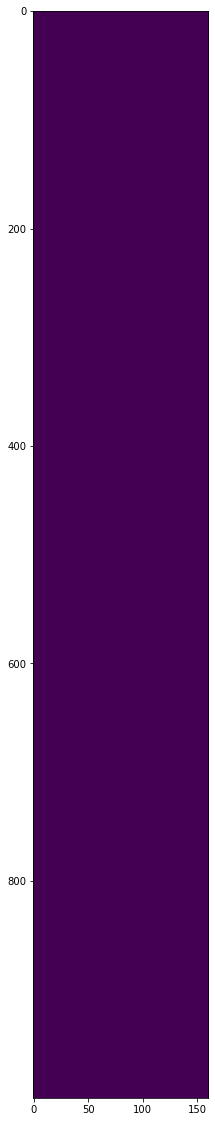

In [57]:
plt.figure(figsize=(20,20))
plt.imshow(cc[1000:2000,:])

In [ ]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v31_pb.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
#     modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
#         pickle.dump([randata,sc_y,sc_X2,modelhistory], file)
          pickle.dump([randata,lb,sc_X2], file)
        
#     !mkdir -p saved_model
#     model.save('saved_model/cnn3v22')